In [91]:
#imports
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [92]:
# read the data
stores_file_path = 'train.csv'
stores_df = pd.read_csv(stores_file_path,index_col='Id')
stores_df

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1             60       RL         65.0     8450   Pave   NaN      Reg   
2             20       RL         80.0     9600   Pave   NaN      Reg   
3             60       RL         68.0    11250   Pave   NaN      IR1   
4             70       RL         60.0     9550   Pave   NaN      IR1   
5             60       RL         84.0    14260   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
1456          60       RL         62.0     7917   Pave   NaN      Reg   
1457          20       RL         85.0    13175   Pave   NaN      Reg   
1458          70       RL         66.0     9042   Pave   NaN      Reg   
1459          20       RL         68.0     9717   Pave   NaN      Reg   
1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... PoolArea PoolQC  Fence MiscFeature  \
Id                                    ...                                      
1            Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
2            Lvl    AllPub       FR2  ...        0    NaN    NaN         NaN   
3            Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
4            Lvl    AllPub    Corner  ...        0    NaN    NaN         NaN   
5            Lvl    AllPub       FR2  ...        0    NaN    NaN         NaN   
...          ...       ...       ...  ...      ...    ...    ...         ...   
1456         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1457         Lvl    AllPub    Inside  ...        0    NaN  MnPrv         NaN   
1458         Lvl    AllPub    Inside  ...        0    NaN  GdPrv        Shed   
1459         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1460         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   

     MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                               
1          0      2    2008        WD         Normal     208500  
2          0      5    2007        WD         Normal     181500  
3          0      9    2008        WD         Normal     223500  
4          0      2    2006        WD        Abnorml     140000  
5          0     12    2008        WD         Normal     250000  
...      ...    ...     ...       ...            ...        ...  
1456       0      8    2007        WD         Normal     175000  
1457       0      2    2010        WD         Normal     210000  
1458    2500      5    2010        WD         Normal     266500  
1459       0      4    2010        WD         Normal     142125  
1460       0      6    2008        WD         Normal     147500  

[1460 rows x 80 columns]

In [93]:
#get X and Y
y = stores_df.SalePrice
X = stores_df.drop('SalePrice',axis = 1)

split_ratio = .8

X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size=split_ratio, test_size=1-split_ratio, random_state=1)

In [94]:
#Preprocess cateogorical data
object_cols = list((X_train.dtypes == 'object')[X_train.dtypes == 'object'].index)

OHE = OneHotEncoder(handle_unknown='ignore',sparse_output=False)

OHE_X_train = pd.DataFrame(OHE.fit_transform(X_train[object_cols]))
OHE_X_valid = pd.DataFrame(OHE.transform(X_valid[object_cols]))

OHE_X_train.index = X_train.index
OHE_X_valid.index = X_valid.index

num_X_train = X_train.drop(object_cols,axis = 1)
num_X_valid = X_valid.drop(object_cols,axis = 1)

OHE_X_train = pd.concat([num_X_train,OHE_X_train],axis = 1)
OHE_X_valid = pd.concat([num_X_valid,OHE_X_valid],axis = 1)

OHE_X_train.columns = OHE_X_train.columns.astype(str)
OHE_X_valid.columns = OHE_X_valid.columns.astype(str)

In [95]:
#Preprocess impute data
imputer = SimpleImputer(strategy='median')

imputed_X_train = pd.DataFrame(imputer.fit_transform(OHE_X_train))
imputed_X_valid = pd.DataFrame(imputer.transform(OHE_X_valid))

imputed_X_train.columns = OHE_X_train.columns
imputed_X_valid.columns = OHE_X_valid.columns


In [100]:
def cost_function(w,b): #add more styles later but for now it will be Mean squared Error
    m = len(X_train)
    prediction = w * imputed_X_train + b
    total_cost = np.sum((y_train - np.sum(prediction,axis=1))**2,axis = 0)
    return total_cost/m

In [131]:
"""
    DERIVE COST FUNCTION TO FIND LOCAL MIN 
    DERIVING MSE = 2/m  * SUM(Y-PREDICTED)
    IF W THEN DERIVE PREDICTION TOO (W IS THE X IN THIS CASE AND B IS A CONSTANT)
    IF B THEN DONT DERIVE PREDICTION
"""
def calculate_derivative(w,b,isW): #derivative is too big needs fix
    m = len(X_train)
    prediction = w * imputed_X_train + b
    total_cost = 0
    if isW:
        total_cost = np.sum((y_train - np.sum(prediction,axis=1)),axis = 0) * imputed_X_train
    else:
        total_cost =  np.sum((y_train - np.sum(prediction,axis=1)),axis = 0)
    return 2 * total_cost/m

In [132]:
"""
FIND THE LOWEST POSSIBLE COST BY CHANGING W AND B
DONE BY USING THE DERIVED W AND B (local mins) AND CHANGING THEM SLIGHTLY EACH TIME UNTIL ANSWER IS REACHED
"""
def gradient_descent(w,b,alpha):
    curW,curB,prevCost = w,b,cost_function(w,b)
    for i in range(1000):
        derivedB = calculate_derivative(curW,curB,False)
        derivedW = calculate_derivative(curW,curB,True)
        #change the w and b iteratively (this is where the bounce happens)
        curW -= alpha * derivedW
        curB -= alpha * derivedB
        
        #find current cost compared to last cost
        cost = cost_function(curW,curB)
        change = prevCost - cost
        prevCost = cost
        
        if change < 0.001:
            break
    return curW,curB

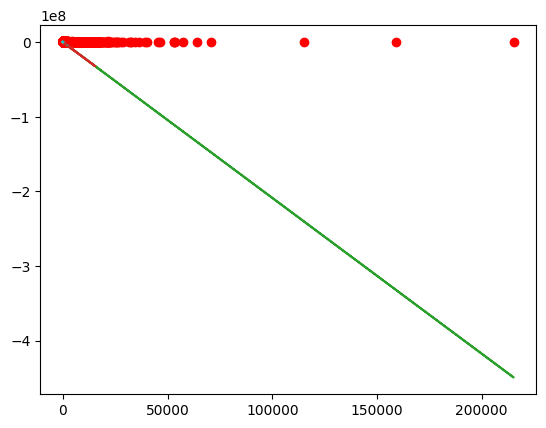

In [133]:
# variables
learning_rate = 0.01
weight = pd.DataFrame(2,index = np.arange(len(imputed_X_train)), columns = imputed_X_train.columns)
bias = 2
weight,bias = gradient_descent(weight,bias,learning_rate)
plt.plot(imputed_X_train,y_train,'ro') # third parameter to make dot plot
plt.plot(imputed_X_train,imputed_X_train * weight + bias)
plt.show()